# find_selectivity_morphlines.py

In [ ]:
import numpy as np

def find_selectivity_morphlines(features):
    nL = len(features[0]) - 1
    nimages = len(features)
    
    # CONSTANTS
    nMorphs = 4
    nDeci = 5  # number of decimals considered
    stim_per_morph = 11
    ref_Set = [0, 11, 22, 33, 10, 21, 32, 43]  # adjusted index for Python
    
    pairs_sel = np.array([[i, j] for i in range(1, nMorphs + 2) for j in range(i + 1, nMorphs + 2)])  # select all combinations
    SEL_CORR = np.zeros((len(pairs_sel), nL))  # all pairwise correlations
    nVAN = np.zeros(nL)  # number of visually responsive neurons across layers.
    nNeu = np.zeros(nL)  # total number of neurons in a layer
    corr_max_sparsness_ref = np.zeros(nL)
    
    for layerid in range(nL):
        # extracting response and normalizing
        nNeurons = len(features[0][layerid])  # number of neurons
        nNeu[layerid] = nNeurons
        response = np.zeros((nNeurons, nimages))  # initializing the matrix
        for ind in range(nimages):
            response[:, ind] = np.ravel(features[ind][layerid])  # extracting the response
        
        nresponse = np.nan_to_num((response - np.min(response)) / (np.max(response) - np.min(response)))  # normalizing each neuron across all images
        van = np.where(np.sum(nresponse, axis=1) > 0)[0]  # visually active neurons
        nvresponse = nresponse[van, :]  # normalized response from visually active neurons
        nvan = len(van)
        nVAN[layerid] = nvan
        
        # finding the sparseness for each morphline
        SPAR = np.zeros((nvan, nMorphs + 1))  # 1 for reference set
        for morphid in range(nMorphs):
            qstim = np.arange(stim_per_morph * morphid, stim_per_morph * (morphid + 1))  # selecting the stim in each morphline
            SPAR[:, morphid] = sparseness(nvresponse[:, qstim])  # some nans will be created
        SPAR[:, nMorphs] = sparseness(nvresponse[:, ref_Set])
        SPAR = np.round(SPAR, nDeci)  # rounding to nDeci decimal places
        
        for ind, (ind_1, ind_2) in enumerate(pairs_sel):
            SEL_CORR[ind, layerid] = np.corrcoef(SPAR[:, ind_1], SPAR[:, ind_2])[0, 1]
        
        max_sparsness = np.nanmax(SPAR[:, :nMorphs], axis=1)  # Max. correlation among four morphilines
        refset_sparsness = SPAR[:, nMorphs]
        corr_max_sparsness_ref[layerid] = np.corrcoef(max_sparsness, refset_sparsness)[0, 1]  # correlation between max sparseness and reference set
    
    return corr_max_sparsness_ref


# find_selectivity_textures_shapes.py

In [ ]:
import numpy as np

def find_selectivity_textures_shapes(features, conditions_ST):
    nL = len(features[0]) - 1
    nimages = len(features)
    set1 = np.arange(conditions_ST)
    set2 = np.arange(conditions_ST, 2 * conditions_ST)
    nM = conditions_ST
    corr_sparsness_texture = np.zeros(nL)
    
    for layerid in range(nL):
        # extracting response and normalizing
        nNeurons = len(np.ravel(features[0][layerid]))  # number of neurons
        response = np.zeros((nNeurons, nimages))  # initializing the matrix
        for ind in range(nimages):
            response[:, ind] = np.ravel(features[ind][layerid])  # extracting the response
        
        nresponse = np.nan_to_num((response - np.min(response)) / (np.max(response) - np.min(response)))  # normalizing each neuron across all images
        
        van_set1 = np.sum(nresponse[:, set1], axis=1) > 0  # visually active neurons for set1
        van_set2 = np.sum(nresponse[:, set2], axis=1) > 0  # visually active neurons for set2
        van = np.where(np.logical_and(van_set1, van_set2))[0]
        nvresponse = nresponse[van, :]  # normalized response from visually active neurons
        nvan = len(van)
        
        # finding the sparseness for each morphline
        np_val = nNeurons
        L = nvan // np_val
        r = nvan % np_val
        SPAR = np.zeros((nvan, 2))  # 1 for reference set
        
        np_val = 4
        for index in range(2):
            qstim = np.arange(nM * index, nM * (index + 1))
            for ii in range(np_val):
                qneu = np.arange(L * ii, L * (ii + 1))
                SPAR[qneu, index] = sparseness(nvresponse[qneu, qstim])  # some nans will be created
            if r > 0:  # when nvan is not divisible by np
                qneu = np.arange(L * np_val, L * np_val + r)
                SPAR[qneu, index] = sparseness(nvresponse[qneu, qstim])  # some nans will be created
        
        corr_sparsness_texture[layerid] = np.corrcoef(SPAR[:, 0], SPAR[:, 1])[0, 1]
    
    return corr_sparsness_texture


# extract_features.py

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

def extract_features(stim_data, types, dagg_flag, run_path):
    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Extract the image data from the loaded dictionary
    stim_images = stim_data['stim'][0]
    nimages = len(stim_images)
    if dagg_flag==0:
        features = []
        for ind in range(nimages):
            # Convert the numpy array to PIL Image
            image_array = stim_images[ind]
            if len(image_array.shape) < 3:
                image_array = np.stack((image_array,) * 3, axis=-1)
            image = Image.fromarray(image_array)

        # Preprocess and normalize the image
            image_tensor = preprocess(image).unsqueeze(0)
            print(image_tensor.shape, " is the shape")
                # Perform inference using the model
#             with torch.no_grad():
#                 output = model(image_tensor)

            # Append the features to the list
            features.append(vl_simplenn(types, image_tensor))
        return features

# layerwise_mi_figures

/tmp/ipykernel_33/2805395727.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  line_colour = plt.cm.get_cmap('tab10')


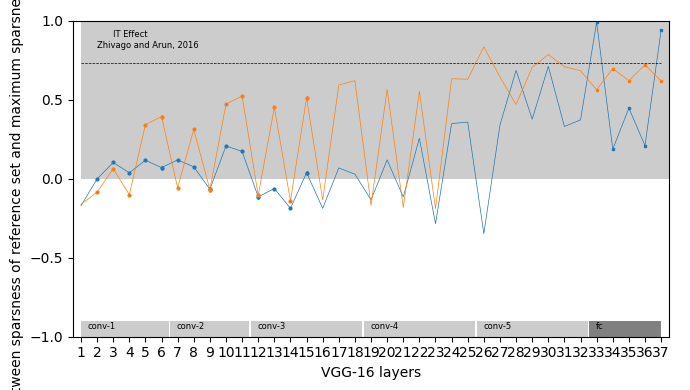

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


def layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi=None, reference_name=None, legend_name=None,
                         y_label=None, shaded_region_name='Human perception', y_limits=None):
    if y_limits is None:
        y_limits = [-1, 1]

    plt.figure(figsize=(7, 4))

    # Drawing the human perception rectangle
    plt.gca().add_patch(Rectangle((1, 0), 37, 1, facecolor=[0.8, 0.8, 0.8], edgecolor='none'))

    # Naming the layers by drawing the bottom rectangles
    layer_grouping = np.array([[1, 6.45], [6.55, 11.45], [11.55, 18.45], [18.55, 25.45], [25.55, 32.45], [32.55, 37]])
    layer_colour = np.vstack([np.tile([0.8, 0.8, 0.8], (5, 1)), [0.5, 0.5, 0.5]])
    box_width = 0.2 / (y_limits[1] - y_limits[0])

    for ind, (start, end) in enumerate(layer_grouping):
        plt.gca().add_patch(
            Rectangle((start, y_limits[0]), end - start, box_width, facecolor=layer_colour[ind], edgecolor='none'))
        plt.text(start + 0.4, y_limits[0] + box_width / 2, ['conv-1', 'conv-2', 'conv-3', 'conv-4', 'conv-5', 'fc'][ind], color='k', fontsize=6)

    # Plotting the data
    line_colour = plt.cm.get_cmap('tab10')
    marker_size = 2
    layer_ind = np.arange(1, 38)
    # print(mean_data)
    # print(np.array(mean_data).shape)
    mean_data = np.array(mean_data)
    for ind in range(mean_data.shape[0]):
        if sem_data is not None and not np.all(np.isnan(sem_data)):
            shadedErrorBar(layer_ind, mean_data[ind], sem_data[ind], lineprops=['-', {'markerfacecolor': line_colour(ind), 'color': line_colour(ind), 'linewidth': 0.5}], transparent=True, patchSaturation=0.3)
        else:
            plt.plot(layer_ind, mean_data[ind], '-', markerfacecolor=line_colour(ind), color=line_colour(ind), linewidth=0.5)

        plt.plot(layer_ind[1:14:2], mean_data[ind, 1:14:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind))
        plt.plot(layer_ind[2:15:2], mean_data[ind, 2:15:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[5:16:3], mean_data[ind, 5:16:3], 'd', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[32:], mean_data[ind, 32:], 's', markersize=marker_size, markeredgecolor=line_colour(ind))

    # Visual search modulation index
    if reference_mi is not None:
        if isinstance(reference_mi, (list, np.ndarray)):
            for i, mi in enumerate(reference_mi):
                plt.plot([1, 37], [mi, mi], '--', color='k', linewidth=0.5)
                plt.text(2, mi + 0.1, reference_name, fontsize=6)
        else:
            plt.plot([1, 37], [reference_mi, reference_mi], '--', color='k', linewidth=0.5)
            plt.text(2, reference_mi + 0.1, reference_name, fontsize=6)

    # Naming the shaded region
    plt.text(3, 0.9, shaded_region_name, fontsize=6)

    plt.xlim(0.5, 37.5)
    plt.ylim(y_limits)
    plt.xticks(range(1, 38))
    plt.yticks(np.linspace(y_limits[0], y_limits[1], 5))

    plt.xlabel('VGG-16 layers')
    plt.ylabel(y_label)

    if legend_name is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, fontsize=6, loc='best', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()
layerwise_mi_figures(mean_data, [], file_name, reference_mi, reference_name, ['VGG16,VGG16_rand'], y_label, shaded_region_name=grey_region_name)

# main.py

In [3]:
import os
import sys
import numpy as np
import scipy.io as sio
from torchvision.models import vgg16
if __name__ == "__main__":
        stim_name = '/kaggle/input/seltos-dataset/seltol.mat'
        stim = sio.loadmat(stim_name)['stim']
        stim_name1 = '/kaggle/input/seltos-dataset/shapes.mat'
        stim_shapes = sio.loadmat(stim_name1)['stim']
        stim_name2 = '/kaggle/input/seltos-dataset/shapes.mat'
        stim_textures = sio.loadmat(stim_name2)['stim']
        conditions_ST = 50
        stim_ST = np.concatenate((stim_shapes[:conditions_ST], stim_textures[:conditions_ST]))
        print(stim)
        typet = []
        time_taken = [None] * len(type)
        MI_across_layers = [None] * len(type)
        network_type = vgg16(pretrained=True)
        network_type2 = vgg16(pretrained=False)
        typet.append(network_type)
        typet.append(network_type2)
        
        # Effect Reference Level
        reference_mi_morph = 0.73
        reference_mi_shapetexture = 0.68
        reference_name = 'Zhivago and Arun, 2016'

        for iter, net_type in enumerate(typet):
            print(f'Network = {net_type}')
            tstart = time.time()
            # Morphlines
            # Extracting Features
            print('\n Extracting Features-Morphlines')
            features = extract_features(stim, net_type, dagg_flag[iter], run_path)
            corr_max_sparsness_ref = find_selectivity_morphlines(features)
            MI_across_layers[iter] = [corr_max_sparsness_ref]

            # Shape vs Textures
            print('\n Extracting Features-Shape-Texture \n')
            features = extract_features(stim_ST, net_type, dagg_flag[iter], run_path)
            corr_sparsness_texture = find_selectivity_textures_shapes(features, conditions_ST)
            MI_across_layers[iter].append(corr_sparsness_texture)

            # Plotting the data
            # Morphlines
            y_label = 'Correlations between sparsness of reference set and maximum sparsness along morphlines'
            if iter <= 3:  # Layer-wise plot for VGG-Network
                layerwise_mi_figures(MI_across_layers[iter][0], [], saving_file_name, reference_mi_morph, reference_name, network_short_name[iter], y_label)
            else:  # Layer-wise plot for other network
                layerwise_mi_nonVGGfigures(MI_across_layers[iter][0], [], saving_file_name, reference_mi_morph, reference_name, network_short_name[iter], y_label)

            # Shape versus Textures
            y_label = 'Correlations between sparsness neuros to texture set versus shapes set'
            if iter <= 3:  # Layer-wise plot for VGG-Network
                layerwise_mi_figures(MI_across_layers[iter][1], [], saving_file_name, reference_mi_shapetexture, reference_name, network_short_name[iter], y_label)
            else:  # Layer-wise plot for other network
                layerwise_mi_nonVGGfigures(MI_across_layers[iter][1], [], saving_file_name, reference_mi_shapetexture, reference_name, network_short_name[iter], y_label)

            time_taken[iter] = time.time() - tstart

        # PLotting the effect of VGG-16 versus random network
        sel_index = [0, 2]
        mean_data_morph = np.zeros((2, 37))
        mean_data_shapetexture = np.zeros((2, 37))
        for ind in range(2):
            mean_data_morph[ind, :] = MI_across_layers[sel_index[ind]][0]
            mean_data_shapetexture[ind, :] = MI_across_layers[sel_index[ind]][1]

        # Morphlines
        y_label_morph = 'Correlations between sparsness of reference set and maximum sparsness along morphlines'
        layerwise_mi_figures(mean_data_morph, [], saving_file_name_morph, reference_mi_morph, reference_name, network_short_name[sel_index], y_label_morph)

        # Shape versus Texture
        y_label_shape = 'Correlations between sparsness neuros to texture set versus shapes set'
        layerwise_mi_figures(mean_data_shapetexture, [], saving_file_name_shape, reference_mi_shapetexture, reference_name, network_short_name[sel_index], y_label_shape)

        # Plotting the effect of VGG-16 versus VGG-16 matconvnet
        sel_index = [0, 1]
        mean_data_morph = np.zeros((2, 37))
        mean_data_shapetexture = np.zeros((2, 37))
        for ind in range(2):
            mean_data_morph[ind, :] = MI_across_layers[sel_index[ind]][0]
            mean_data_shapetexture[ind, :] = MI_across_layers[sel_index[ind]][1]

[[array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],


TypeError: object of type 'type' has no len()